In [1]:
import numpy as np
import pandas as pd

#for mapping
import folium

#library to handle requests
import requests

#get coordinates
!pip install geopy
from geopy.geocoders import Nominatim

#handle json files
import json
from pandas.io.json import json_normalize #flatten json

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

     |████████████████████████████████| 112kB 3.2MB/s eta 0:00:01


In [2]:
#get population of each neighbourhood in Toronto
!wget -q -O 'wellbeing-toronto-population-total-2011-2016-and-age-groups-2016.xlsx' https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/2fd345a6-4107-49c1-b439-5ba0abe011d7
xls = pd.ExcelFile('wellbeing-toronto-population-total-2011-2016-and-age-groups-2016.xlsx')
df = pd.read_excel(xls, '016 Pop_TotalChange')
df.head()

,HoodID,Neighbourhood,Pop2016,Pop2011,PopChg11t16
0,1,West Humber-Clairville,33312,34100,-0.023109
1,2,Mount Olive-Silverstone-Jamestown,32954,32788,0.005063
2,3,Thistletown-Beaumond Heights,10360,10138,0.021898
3,4,Rexdale-Kipling,10529,10488,0.003909
4,5,Elms-Old Rexdale,9456,9550,-0.009843


In [3]:
#project population to 2020
df['Project'] = df['PopChg11t16']/5*4
df['Pop2020'] = (df['Pop2016'] * (df['Project']+1)).astype(int)
df

,HoodID,Neighbourhood,Pop2016,Pop2011,PopChg11t16,Project,Pop2020
0,1,West Humber-Clairville,33312,34100,-0.023109,-0.018487,32696
1,2,Mount Olive-Silverstone-Jamestown,32954,32788,0.005063,0.004050,33087
2,3,Thistletown-Beaumond Heights,10360,10138,0.021898,0.017518,10541
3,4,Rexdale-Kipling,10529,10488,0.003909,0.003127,10561
4,5,Elms-Old Rexdale,9456,9550,-0.009843,-0.007874,9381
...,...,...,...,...,...,...,...
135,136,West Hill,27392,26547,0.031830,0.025464,28089
136,137,Woburn,53485,53350,0.002530,0.002024,53593
137,138,Eglinton East,22776,22829,-0.002322,-0.001857,22733
138,139,Scarborough Village,16724,16609,0.006924,0.005539,16816


In [4]:
#setup dataframe for the last accurate population and projected population
pop = df[['HoodID','Neighbourhood','Pop2016','Pop2020']]
pop

,HoodID,Neighbourhood,Pop2016,Pop2020
0,1,West Humber-Clairville,33312,32696
1,2,Mount Olive-Silverstone-Jamestown,32954,33087
2,3,Thistletown-Beaumond Heights,10360,10541
3,4,Rexdale-Kipling,10529,10561
4,5,Elms-Old Rexdale,9456,9381
...,...,...,...,...
135,136,West Hill,27392,28089
136,137,Woburn,53485,53593
137,138,Eglinton East,22776,22733
138,139,Scarborough Village,16724,16816


In [5]:
#read neighbourhood location data
df = pd.read_csv('Neighbourhoods.csv')
print(df.shape)
df.head()

(140, 16)


,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,5881,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),NaN,NaN,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
1,5882,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),NaN,NaN,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
2,5883,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),NaN,NaN,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"{u'type': u'Polygon', u'coordinates': (((-79.3..."
3,5884,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),NaN,NaN,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"{u'type': u'Polygon', u'coordinates': (((-79.5..."
4,5885,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),NaN,NaN,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"{u'type': u'Polygon', u'coordinates': (((-79.4..."


In [6]:
#setup dataframe for neighbourhood location data
regions = df[['AREA_LONG_CODE','AREA_NAME','LONGITUDE','LATITUDE']]
regions.head()

,AREA_LONG_CODE,AREA_NAME,LONGITUDE,LATITUDE
0,94,Wychwood (94),-79.425515,43.676919
1,100,Yonge-Eglinton (100),-79.403590,43.704689
2,97,Yonge-St.Clair (97),-79.397871,43.687859
3,27,York University Heights (27),-79.488883,43.765736
4,31,Yorkdale-Glen Park (31),-79.457108,43.714672


In [7]:
#merge population and neighbourhood location dataframes
df2 = pd.merge(pop, regions, left_on='HoodID', right_on='AREA_LONG_CODE') #merges based on matching Postal Code
df2.rename(columns={'LONGITUDE': 'Longitude', 'LATITUDE': 'Latitude'}, inplace=True)

In [8]:
#finalize merged dataframe
toronto = df2[['Neighbourhood','Pop2016','Pop2020','Longitude','Latitude']]
toronto

,Neighbourhood,Pop2016,Pop2020,Longitude,Latitude
0,West Humber-Clairville,33312,32696,-79.596356,43.716180
1,Mount Olive-Silverstone-Jamestown,32954,33087,-79.587259,43.746868
2,Thistletown-Beaumond Heights,10360,10541,-79.563491,43.737988
3,Rexdale-Kipling,10529,10561,-79.566228,43.723725
4,Elms-Old Rexdale,9456,9381,-79.548983,43.721519
...,...,...,...,...,...
135,West Hill,27392,28089,-79.176676,43.767490
136,Woburn,53485,53593,-79.228586,43.766740
137,Eglinton East,22776,22733,-79.245598,43.740922
138,Scarborough Village,16724,16816,-79.216813,43.738652


In [9]:
list_tor = toronto.copy()
list_tor = list_tor.sort_values('Pop2016', ascending=False)
#list_tor.set_index('Neighbourhood', inplace = True)
bar_list_tor = list_tor.head(20)
bar_list_tor.set_index('Neighbourhood', inplace=True)
bar_list_tor.sort_values(by='Pop2016', ascending=True, inplace=True)
#list_tor.head(10).style.hide_index()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


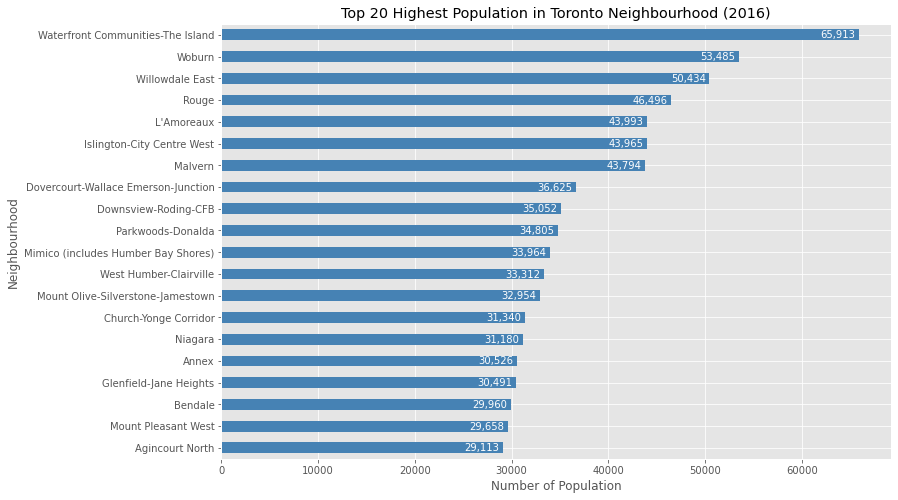

In [10]:
mpl.style.use('ggplot')

bar_list_tor['Pop2016'].plot(kind='barh', figsize=(12, 8), color='steelblue')
plt.xlabel('Number of Population')
plt.title('Top 20 Highest Population in Toronto Neighbourhood (2016)')

# annotate value labels to each country
for index, value in enumerate(bar_list_tor['Pop2016']): 
    label = format(int(value), ',') # format int with commas
    
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value - 4000, index - 0.15), color='white')


plt.show()

In [11]:
#setup for map of Toronto
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [12]:
#show map of Toronto with neighbourhood information
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighbourhood, population in zip(toronto['Latitude'], toronto['Longitude'], toronto['Neighbourhood'], toronto['Pop2016']):
    label = '{}, {}'.format(neighbourhood, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [13]:
#Foursquare credential
CLIENT_ID = 'QWBR5KBJB0VKUWA1NDAKUNMUSLRJ303OV1CJPM4YR0B1XMQZ' # your Foursquare ID
CLIENT_SECRET = '2ZFI0FQVAROVTZN2B5RDTJATOZBN2XGNYYQ5TYBN3IZOGZOP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QWBR5KBJB0VKUWA1NDAKUNMUSLRJ303OV1CJPM4YR0B1XMQZ
CLIENT_SECRET:2ZFI0FQVAROVTZN2B5RDTJATOZBN2XGNYYQ5TYBN3IZOGZOP


In [12]:
#pick a test neighbourhood to check foursquare
toronto.loc[0, 'Neighbourhood']

'West Humber-Clairville'

In [13]:
#get coordinate of the test neighbourhood from toronto dataframe
neighbourhood_latitude = toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = toronto.loc[0, 'Longitude'] # neighborhood longitude value
neighbourhood_name = toronto.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of West Humber-Clairville are 43.7161804033, -79.59635645350001.


In [14]:
#setup search for Cafés within 2km radius of the test neighbourhood
limit = 100
radius = 2000

Café = '4bf58dd8d48988d16d941735'

categoryId = Café

url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(categoryId, CLIENT_ID, CLIENT_SECRET, VERSION, neighbourhood_latitude, neighbourhood_longitude, radius, limit)
url

'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d16d941735&intent=browse&client_id=QWBR5KBJB0VKUWA1NDAKUNMUSLRJ303OV1CJPM4YR0B1XMQZ&client_secret=2ZFI0FQVAROVTZN2B5RDTJATOZBN2XGNYYQ5TYBN3IZOGZOP&v=20180605&ll=43.7161804033,-79.59635645350001&radius=2000&limit=100'

In [15]:
#display search result to look for key terms
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5efd2f4434f8b76b95216a1f'},
 'response': {'venues': [{'id': '553e914a498e6d51a2161ef6',
    'name': 'Starbucks',
    'location': {'address': '205 Humber College Blvd',
     'lat': 43.72867,
     'lng': -79.608169,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.72867,
       'lng': -79.608169}],
     'distance': 1684,
     'postalCode': 'M9W 5L7',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['205 Humber College Blvd',
      'Toronto ON M9W 5L7',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d1e0931735',
      'name': 'Coffee Shop',
      'pluralName': 'Coffee Shops',
      'shortName': 'Coffee Shop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1593651362',
    'hasPerk': False},
   {'id': '5058aff2e4b01987c85db1f8',
    'name': 'Williams Fresh Ca

In [16]:
#function to return venue categories
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
#display venues in a list
venues = results['response']['venues']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['name', 'categories']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.drop(columns=['categories'], inplace=True)

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,venue.categories
0,Starbucks,Coffee Shop
1,Williams Fresh Cafe,Café
2,JJ Cafe,Café
3,Humber Cafe,Café
4,GH Cafe,Café


In [19]:
#function to get nearby venues within 2km of neighbourhood
def getNearbyVenues(names, latitudes, longitudes, categoryId, radius=2000, limit=200):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            categoryId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Longitude',
                  'Neighbourhood Latitude',
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
#function to get result based on number of competition in each neighbourhood
def getCompetitions(competition):

    toronto_venues = getNearbyVenues(names=toronto['Neighbourhood'],
                                 latitudes=toronto['Latitude'],
                                 longitudes=toronto['Longitude'],
                                 categoryId=competition)

    #show number of results
    print(toronto_venues.shape)
    return(toronto_venues)

In [41]:
#search ID for potential competitions
Bagel_Shop = '4bf58dd8d48988d179941735'
Bakery = '4bf58dd8d48988d16a941735'
Bubble_Tea_Shop = '52e81612bcbc57f1066b7a0c'
Café = '4bf58dd8d48988d16d941735'
Coffee_Shop = '4bf58dd8d48988d1e0931735'
Dessert_Shop = '4bf58dd8d48988d1d0941735'
Donut_Shop = '4bf58dd8d48988d148941735'
Fast_Food_Restaurant = '4bf58dd8d48988d16e941735'
Gaming_Cafe = '4bf58dd8d48988d18d941735'
Sandwich_Place = '4bf58dd8d48988d1c5941735'
Tea_Room = '4bf58dd8d48988d1dc931735'

In [22]:
#get result of number of Bubble Tea Shop in each neighbourhood
temp = getCompetitions(Bubble_Tea_Shop)

In [23]:
#get result of number of Café in each neighbourhood
#temp = getCompetitions(Café)

(3383, 5)


In [24]:
#get result of number of coffee shop in each neighbourhood
temp = temp.append(getCompetitions(Coffee_Shop), ignore_index = True)

In [25]:
#get result of number of Café in each neighbourhood
temp = temp.append(getCompetitions(Café), ignore_index = True)

In [26]:
#get result of number of Fast_Food_Restaurant in each neighbourhood
temp = temp.append(getCompetitions(Fast_Food_Restaurant), ignore_index = True)

(2826, 5)


In [28]:
#read in any previous results and show total result
toronto_venues=pd.read_csv('toronto_venues.csv')
temp = temp.append(toronto_venues, ignore_index = True)
print(temp.shape)

(10727, 6)


In [34]:
#Since venues can have multiple hidden sub categories from foursquare, drop any duplicates
temp.drop_duplicates(keep=False, inplace=True)
print(temp.shape)

(8321, 6)


In [23]:
#save to toronto_venues.csv
temp.to_csv('toronto_venues.csv')

NameError: name 'temp' is not defined

In [14]:
#read in result from toronto_venues.csv
toronto_venues=pd.read_csv('toronto_venues.csv')
toronto_venues.drop(columns=['Unnamed: 0'], inplace=True)

In [15]:
toronto_venues

,Neighbourhood,Neighbourhood Longitude,Neighbourhood Latitude,Venue,Venue Category,Unnamed: 0.1
0,West Humber-Clairville,43.716180,-79.596356,Starbucks,Coffee Shop,NaN
1,West Humber-Clairville,43.716180,-79.596356,Williams Fresh Cafe,Café,NaN
2,West Humber-Clairville,43.716180,-79.596356,JJ Cafe,Café,NaN
3,West Humber-Clairville,43.716180,-79.596356,Humber Cafe,Café,NaN
4,West Humber-Clairville,43.716180,-79.596356,GH Cafe,Café,NaN
...,...,...,...,...,...,...
8316,Guildwood,43.748829,-79.195055,Tim Hortons,Coffee Shop,4513.0
8317,Guildwood,43.748829,-79.195055,Tim Hortons,Coffee Shop,4514.0
8318,Guildwood,43.748829,-79.195055,Gateway On The Go (Guildwood GO/VIA Station),Coffee Shop,4515.0
8319,Guildwood,43.748829,-79.195055,Tim Hortons Drive-Thru,Coffee Shop,4516.0


In [16]:
#group number of competition by neighbourhood
num_com = toronto_venues.groupby('Neighbourhood').count()
com_show = pd.DataFrame(num_com['Venue'])
com_show.rename(columns={'Venue':'Number of Competitions'}, inplace=True)
com_show.reset_index(inplace=True)
com_show.sort_values(by='Number of Competitions', ascending=False, inplace=True)
#com_show.head(20).style.hide_index()
bar_com_show = com_show.head(10)
bar_com_show.reset_index(drop=True, inplace=True)
#bar_com_show.set_index('Neighbourhood', inplace=True)
#bar_com_show.sort_values(by='Number of Competitions', ascending=True, inplace=True)
bar_com_show.index = bar_com_show.index + 1
bar_com_show

,Neighbourhood,Number of Competitions
1,University,149
2,Annex,149
3,Kensington-Chinatown,144
4,Palmerston-Little Italy,144
5,Bay Street Corridor,142
6,Cabbagetown-South St. James Town,142
7,Moss Park,142
8,North St. James Town,141
9,Trinity-Bellwoods,141
10,Church-Yonge Corridor,139


In [17]:
add=com_show.loc[com_show['Neighbourhood'].str.contains('Glenfield')]
#add.set_index('Neighbourhood', inplace=True)
add

,Neighbourhood,Number of Competitions
45,Glenfield-Jane Heights,11


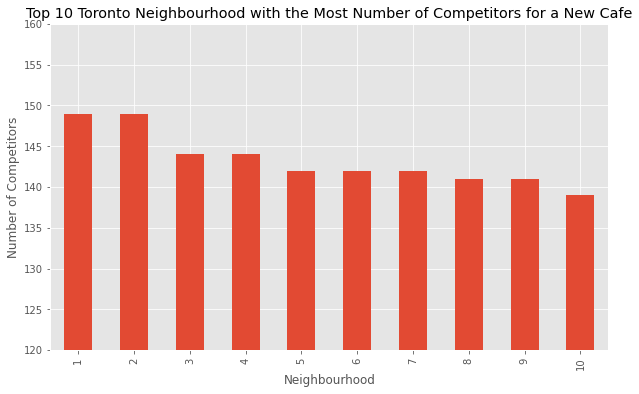

In [18]:
bar_com_show.plot(kind='bar', figsize=(10, 6), legend=None, ylim=(120,160))

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Number of Competitors') # add y-label to the plot
plt.title('Top 10 Toronto Neighbourhood with the Most Number of Competitors for a New Cafe') # add title to the plot

plt.show()

In [19]:
#setup dataframe with neighbourhood and their number of competitions
num_com2 = num_com[['Venue']]
num_com2.reset_index(inplace=True)
num_com2

#display total number of competition
print('Total competition:', num_com2['Venue'].sum())

Total competition: 8321


In [20]:
#combine toronto data and number of competitions
tor_com = pd.merge(toronto, num_com2, on='Neighbourhood', how='outer')
tor_com['Venue'].fillna(0, inplace=True)
tor_com['Venue'] = tor_com['Venue'].astype(int)
tor_com.rename(columns={'Venue':'Competitions'}, inplace=True)

#calculate competition per capita
tor_com['Competition per Capita'] = tor_com['Competitions'] / tor_com['Pop2016']
tor_com['Ratio'] = tor_com['Pop2016'] / tor_com['Competitions']
tor_com.sort_values(by=['Competition per Capita', 'Pop2016'], ascending=[True, False], inplace=True)
tor_com.reset_index(drop=True, inplace=True)

In [21]:
#result top location for our café
tc_display = tor_com.copy()
tc_display = tc_display[['Neighbourhood','Pop2016','Competitions','Competition per Capita','Ratio']]
tc_display.rename(columns={'Pop2016':'Population'}, inplace=True)
bar_tc_display = tc_display.head(5)
bar_tc_display.set_index('Neighbourhood', inplace=True)
#bar_tc_display.drop(columns=['Competition per Capita', 'Ratio'], inplace=True)

In [22]:
tc_display.head(10).style.hide_index()

Neighbourhood,Population,Competitions,Competition per Capita,Ratio
Rouge,46496,6,0.000129,7749.333333
Glenfield-Jane Heights,30491,11,0.000361,2771.909091
West Hill,27392,11,0.000402,2490.181818
L'Amoreaux,43993,18,0.000409,2444.055556
Malvern,43794,19,0.000434,2304.947368
Downsview-Roding-CFB,35052,16,0.000456,2190.750000
Eglinton East,22776,12,0.000527,1898.000000
Woburn,53485,29,0.000542,1844.310345
Cliffcrest,15935,9,0.000565,1770.555556
Mount Olive-Silverstone-Jamestown,32954,19,0.000577,1734.421053


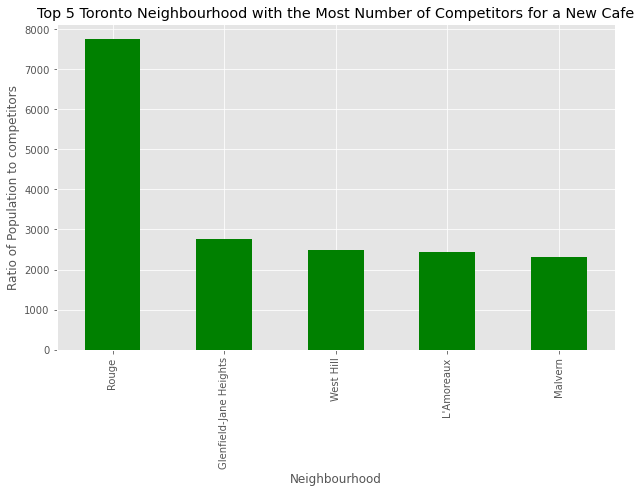

In [23]:
mpl.style.use('ggplot')
bar_tc_display['Ratio'].plot(kind='bar', color=['green'], figsize=(10, 6))

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Ratio of Population to competitors') # add y-label to the plot
plt.title('Top 5 Toronto Neighbourhood with the Most Number of Competitors for a New Cafe') # add title to the plot

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f41db3e6ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f41db3fa0b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f41db3e6860>],
 'medians': [<matplotlib.lines.Line2D at 0x7f41db3fa668>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f41db3fa940>],
 'means': []}

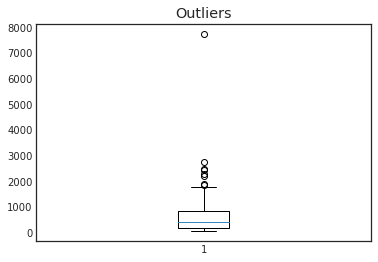

In [24]:
mpl.style.use('seaborn-white')

fig1, ax1 = plt.subplots()
ax1.set_title('Outliers')
ax1.boxplot(tc_display['Ratio'])

In [25]:
#sorted dataframe using project population for 2020
tor_com20 = tor_com.copy()
tor_com20.sort_values(by=['Competition per Capita', 'Pop2020'], ascending=[True, False], inplace=True)

In [26]:
#result top location for our café in 2020
tor_com20.head()

,Neighbourhood,Pop2016,Pop2020,Longitude,Latitude,Competitions,Competition per Capita,Ratio
0,Rouge,46496,46969,-79.186343,43.821201,6,0.000129,7749.333333
1,Glenfield-Jane Heights,30491,29792,-79.513465,43.745636,11,0.000361,2771.909091
2,West Hill,27392,28089,-79.176676,43.767490,11,0.000402,2490.181818
3,L'Amoreaux,43993,43267,-79.314084,43.795716,18,0.000409,2444.055556
4,Malvern,43794,42790,-79.222517,43.803658,19,0.000434,2304.947368


In [27]:
latitude = tor_com.loc[0, 'Latitude']
longitude = tor_com.loc[0, 'Longitude']

map_rouge = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
label = toronto['Pop2016']
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rouge)  
    
map_rouge

In [28]:
latitude = tor_com.loc[1, 'Latitude']
longitude = tor_com.loc[1, 'Longitude']

map_Glenfield = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
label = toronto['Pop2016']
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Glenfield)  
    
map_Glenfield

In [29]:
#top_comp=pd.DataFrame(toronto_venues.groupby('Venue')['Unnamed: 0.1'].nunique().sort_values(ascending=False))
#top_comp.rename(columns={"Unnamed: 0.1": "Count"}, inplace=True)
#top_comp.reset_index(inplace=True)
top_comp=pd.DataFrame(toronto_venues['Venue'].value_counts())

In [30]:
top_comp.head(20)

,Venue
Tim Hortons,1017
Starbucks,741
Second Cup,175
Coffee Time,120
Country Style,96
Timothy's World Coffee,74
Chatime,67
KFC,58
Aroma Espresso Bar,56
Wendy’s,47


In [31]:
add2=toronto_venues.loc[toronto_venues['Neighbourhood'].str.contains('Glenfield')]
add2

,Neighbourhood,Neighbourhood Longitude,Neighbourhood Latitude,Venue,Venue Category,Unnamed: 0.1
170,Glenfield-Jane Heights,43.745636,-79.513465,Commisso Bakery,Tea Room,NaN
2810,Glenfield-Jane Heights,43.745636,-79.513465,KFC,Fast Food Restaurant,NaN
2811,Glenfield-Jane Heights,43.745636,-79.513465,The Wing Machine,Wings Joint,NaN
2812,Glenfield-Jane Heights,43.745636,-79.513465,Taco Bell,Restaurant,NaN
2813,Glenfield-Jane Heights,43.745636,-79.513465,Subway,Sandwich Place,NaN
5022,Glenfield-Jane Heights,43.745636,-79.513465,Country Style,Coffee Shop,1219.0
5023,Glenfield-Jane Heights,43.745636,-79.513465,Tim Hortons,Coffee Shop,1220.0
5024,Glenfield-Jane Heights,43.745636,-79.513465,Commisso Bakery,Tea Room,1221.0
5025,Glenfield-Jane Heights,43.745636,-79.513465,Tim Hortons,Coffee Shop,1222.0
5026,Glenfield-Jane Heights,43.745636,-79.513465,Tim Hortons,Coffee Shop,1223.0


In [32]:
add3=pd.DataFrame(add2['Venue'].value_counts()).head(3)

In [33]:
add3

,Venue
Tim Hortons,3
Country Style,2
Commisso Bakery,2


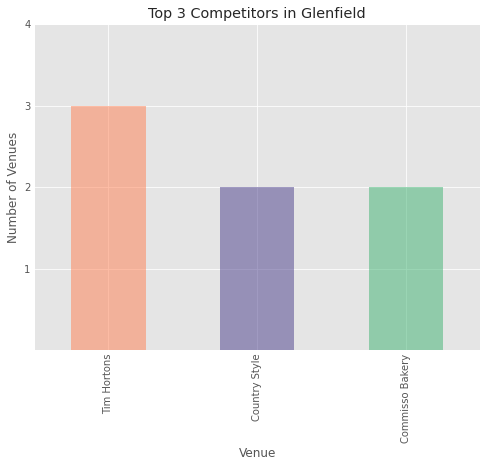

In [34]:
mpl.style.use('ggplot')
add3['Venue'].plot(kind='bar', figsize=(8, 6), yticks=[1,2,3,4], alpha=0.5, color=['coral','darkslateblue','mediumseagreen'])

plt.xlabel('Venue') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 3 Competitors in Glenfield') # add title to the plot

plt.show()